In [1]:
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
import networkx as nx
import city2graph as c2g
import city2graph.morphology as c2g_morpho

import matplotlib.pyplot as plt

# Configurações visuais e de sistema
pd.set_option('display.max_columns', None)

print("Bibliotecas carrorororegadas com sucesso!")

# Configure matplotlib for publication-quality visualizations
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10
plt.style.use('ggplot')

print("Parametros globais de gráfico!")

Bibliotecas carrorororegadas com sucesso!
Parametros globais de gráfico!


In [2]:
# ============================================
# CONFIGURAÇÕES GLOBAIS
# ============================================

CRS_METRICO = "EPSG:31983" #SIRGAS 2000 / UTM ZONA 23 SUL

## 2. Carregando os Dados

In [3]:
# ============================================
# CARREGAMENTO DA REDE VIÁRIA DE TERESINA
# ============================================

# DEFINA OS CAMINHOS DOS SEUS ARQUIVOS AQUI
caminho_segments = Path("../outputs/vectors/teresina_bbox_gnn_impedancias_2.gpkg")
nome_camada = caminho_segments.stem

# 1. Carregar os dados
print(f"Carregando arquivos '{nome_camada}'...\n")
roads_gdf = gpd.read_file(caminho_segments)
print("Arquivos carregadas")

Carregando arquivos 'teresina_bbox_gnn_impedancias_2'...

Arquivos carregadas


Total de Trechos (Arestas): 66444


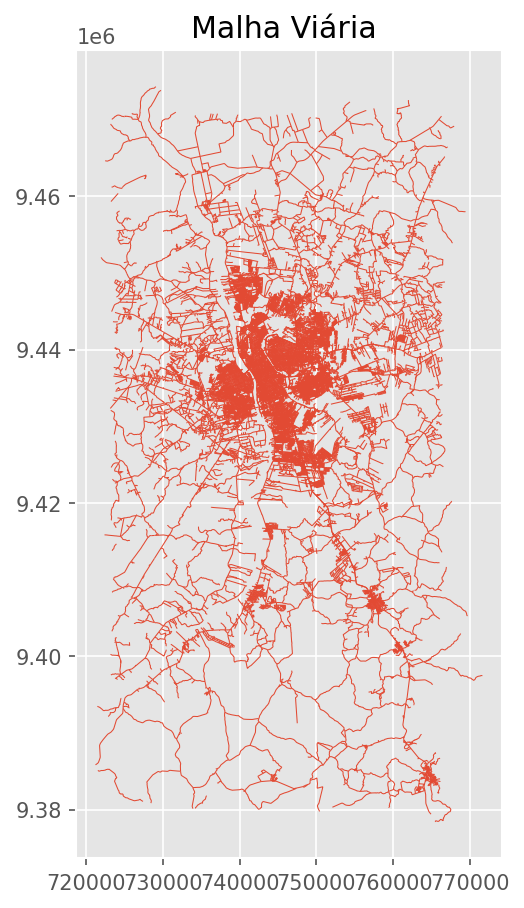

In [4]:
if roads_gdf.crs != '31983':
    print(f"Sistema de coordenadas da fonte (EPSG{roads_gdf.crs.to_epsg()}) é diferente de (CRS_METRICO={CRS_METRICO})")
    print("Reprojetando para UTM Zona 23S (Metros)...\n")
    roads_gdf = roads_gdf.to_crs(CRS_METRICO)


#gdf_connectors = gdf_connectors.to_crs(CRS_METRICO)

# Visualização rápida para confirmar
print(f"Total de Trechos (Arestas): {len(roads_gdf)}")
roads_gdf.plot(linewidth=0.5, figsize=(10, 7))
plt.title("Malha Viária ")
plt.show()

In [5]:
print("Convertendo malha viária para Grafo NetworkX...")

# approach='primal': Nós são intersecções, Arestas são ruas
G = c2g_morpho.segments_to_graph(
    segments_gdf = roads_gdf,
    multigraph = False,
    as_nx = True,
)

print("Grafo criado com sucesso!")
print(f"Número de Nós: {G.number_of_nodes()}")
print(f"Número de Arestas: {G.number_of_edges()}")

# 2. Verificação de Atributos
# Vamos confirmar se as colunas de tempo entraram no grafo
exemplo_aresta = list(G.edges(data=True))[20000] # Pega a primeira rua
print("\n--- ATRIBUTOS DA PRIMEIRA ARESTA ---")
print(f"Tempo Carro: {exemplo_aresta[2].get('time_carro_min')} min")
print(f"Tempo Pé:    {exemplo_aresta[2].get('time_ape_min')} min")

Convertendo malha viária para Grafo NetworkX...
Grafo criado com sucesso!
Número de Nós: 48398
Número de Arestas: 66128

--- ATRIBUTOS DA PRIMEIRA ARESTA ---
Tempo Carro: 0.055923688135308826 min
Tempo Pé:    None min


In [6]:
# Célula: Tratamento e Exportação de Componentes Desconexos

print("Iniciando diagnóstico de conectividade...")

# 1. Identificar Componentes
# nx.connected_components retorna geradores de conjuntos de nós
componentes = list(nx.connected_components(G))

print(f"Total de componentes encontrados: {len(componentes)}")

if len(componentes) > 1:
    # 2. Separar o Joio do Trigo
    # Ordena do maior para o menor
    componentes.sort(key=len, reverse=True)
    
    # O primeiro é o maior (Rede Principal)
    maior_componente_nos = componentes[0]
    
    # O resto são as ilhas (juntamos todas numa lista só)
    ilhas_nos = []
    for comp in componentes[1:]:
        ilhas_nos.extend(list(comp))
        
    print(f"   - Rede Principal: {len(maior_componente_nos)} nós")
    print(f"   - Ilhas Desconectadas: {len(ilhas_nos)} nós (serão exportadas)")

    # 3. Criar Subgrafos
    # Grafo Principal (para continuar o trabalho)
    G_principal = G.subgraph(maior_componente_nos).copy()
    
    # Grafo das Ilhas (para auditoria)
    G_ilhas = G.subgraph(ilhas_nos).copy()

    # 4. Exportação das Ilhas (Converter para GeoDataFrame)
    try:
        print("   Preparando exportação das ilhas...")
        # Convertemos apenas arestas (lines=True), pontos não precisa para visualização
        gdf_ilhas = c2g.utils.nx_to_gdf(G_ilhas, nodes=False, edges=True)
        
        # --- SANITIZAÇÃO (Igual ao script anterior) ---
        # Garante que listas virem texto para não quebrar o GeoPackage
        for col in gdf_ilhas.columns:
            if gdf_ilhas[col].apply(lambda x: isinstance(x, (list, dict, tuple))).any():
                gdf_ilhas[col] = gdf_ilhas[col].astype(str)

        # Salvar
        pasta_saida = "../dados/processados/overturemaps/"
        os.makedirs(pasta_saida, exist_ok=True)
        path_ilhas = os.path.join(pasta_saida, "trechos_desconectados_audit_2.gpkg")
        
        gdf_ilhas.to_file(path_ilhas, driver="GPKG")
        print(f"   ✅ Arquivo de auditoria salvo: {path_ilhas}")
        print("   (Abra este arquivo no QGIS para ver o que foi removido)")

    except Exception as e:
        print(f"   ⚠️ Erro ao exportar ilhas: {e}")

    # Atualiza a variável G para ser apenas o principal
    G = G_principal

else:
    print("   Sucesso: O grafo já é totalmente conectado. Nada a exportar.")

print(f"Grafo Final pronto com {len(G.nodes)} nós.")

Iniciando diagnóstico de conectividade...
Total de componentes encontrados: 3367
   - Rede Principal: 40969 nós
   - Ilhas Desconectadas: 7429 nós (serão exportadas)
   Preparando exportação das ilhas...
   ✅ Arquivo de auditoria salvo: ../dados/processados/overturemaps/trechos_desconectados_audit_2.gpkg
   (Abra este arquivo no QGIS para ver o que foi removido)
Grafo Final pronto com 40969 nós.


In [7]:
# 3. Verificação de Atributos (Crucial)
# Precisamos confirmar se 'time_car_min' sobreviveu à conversão
try:
    exemplo = list(G.edges(data=True))[0]
    print("\n--- AUDITORIA DE ATRIBUTOS (Primeira Aresta) ---")
    print(f"Classe: {exemplo[2].get('class', 'N/A')}")
    print(f"Tempo Carro: {exemplo[2].get('time_carro_min'):.4f} min")
    print(f"Tempo Pé (adulto normal):    {exemplo[2].get('time_ape_adulto_min'):.4f} min")
    print(f"Tempo Pé (adulto idoso):    {exemplo[2].get('time_ape_idoso_min'):.4f} min")
except Exception as e:
    print(f"ERRO CRÍTICO: Atributos perdidos na conversão. Detalhe: {e}")


--- AUDITORIA DE ATRIBUTOS (Primeira Aresta) ---
Classe: residential
Tempo Carro: 2.1613 min
Tempo Pé (adulto normal):    10.8067 min
Tempo Pé (adulto idoso):    28.8180 min


In [8]:
gdf_nodes, gdf_edges = c2g.nx_to_gdf(G, nodes=True, edges=True)

# Salvamento temporário para inspeção no QGIS
gdf_nodes.to_file(
        "../outputs/vectors/teresina_bbox_gnn_impedancias_topologico_nodes_2.gpkg", 
        layer='teresina_bbox_gnn_impedancias_topologico_nodes_2', 
        driver='GPKG'
)

# Salvamento temporário para inspeção no QGIS
gdf_edges.to_file(
        "../outputs/vectors/teresina_bbox_gnn_impedancias_topologico_edges_2.gpkg", 
        layer='teresina_bbox_gnn_impedancias_topologico_edges_2', 
        driver='GPKG'
)